In [1]:
### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Import packets and collect data

In [2]:
from __future__ import print_function, division
from builtins import range, input

import tensorflow as tf
print(tf.__version__)

# import model 
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential 
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, GlobalMaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D


from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

2.4.1


In [6]:
train_path = '../input/fruits/fruits-360/Training/'
test_path = '../input/fruits/fruits-360/Test/'

fruits = []
fruits_image = []
for i in os.listdir(train_path):
    for image_filename in os.listdir(train_path + i):
        fruits.append(i) # name of the fruit 
        fruits_image.append(i + '/' + image_filename) # image of the fruit
        
train_fruits = pd.DataFrame(fruits, columns=["Fruits"])
train_fruits["Fruits Image"] = fruits_image

In [40]:
from pathlib import Path
# Create a list with the filepaths for training and testing
train_dir = Path('../input/fruits/fruits-360/Training')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('../input/fruits/fruits-360/Test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)

print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

Number of pictures: 67692

Number of different labels: 131

Labels: ['Cauliflower' 'Pineapple' 'Pitahaya Red' 'Kiwi' 'Potato White'
 'Mango Red' 'Pineapple Mini' 'Maracuja' 'Papaya' 'Banana Red' 'Physalis'
 'Nectarine Flat' 'Cherry 2' 'Pear Forelle' 'Grape White 2' 'Tomato 2'
 'Grape Blue' 'Quince' 'Apple Crimson Snow' 'Pear 2' 'Potato Sweet' 'Pear'
 'Peach 2' 'Lemon' 'Watermelon' 'Cocos' 'Apple Golden 2' 'Tomato Heart'
 'Corn Husk' 'Physalis with Husk' 'Guava' 'Tomato 1' 'Dates' 'Clementine'
 'Cactus fruit' 'Melon Piel de Sapo' 'Apricot' 'Apple Red Yellow 1'
 'Carambula' 'Huckleberry' 'Strawberry Wedge' 'Banana Lady Finger'
 'Pear Monster' 'Plum 2' 'Tomato Maroon' 'Cantaloupe 2' 'Chestnut'
 'Tangelo' 'Nut Forest' 'Apple Granny Smith' 'Grape Pink' 'Granadilla'
 'Grape White' 'Apple Pink Lady' 'Grape White 3' 'Potato Red Washed'
 'Peach' 'Apple Golden 3' 'Cherry Rainier' 'Kohlrabi' 'Plum 3'
 'Pomelo Sweetie' 'Nectarine' 'Pear Williams' 'Tomato 3' 'Eggplant'
 'Cantaloupe 1' 'Grapefruit P

,Filepath,Label
0,../input/fruits/fruits-360/Training/Cauliflowe...,Cauliflower
1,../input/fruits/fruits-360/Training/Pineapple/...,Pineapple
2,../input/fruits/fruits-360/Training/Pitahaya R...,Pitahaya Red
3,../input/fruits/fruits-360/Training/Kiwi/r_236...,Kiwi
4,../input/fruits/fruits-360/Training/Potato Whi...,Potato White


In [7]:
train_fruits

,Fruits,Fruits Image
0,Quince,Quince/r_305_100.jpg
1,Quince,Quince/139_100.jpg
2,Quince,Quince/128_100.jpg
3,Quince,Quince/r_239_100.jpg
4,Quince,Quince/185_100.jpg
...,...,...
67687,Tomato 2,Tomato 2/129_100.jpg
67688,Tomato 2,Tomato 2/r2_144_100.jpg
67689,Tomato 2,Tomato 2/9_100.jpg
67690,Tomato 2,Tomato 2/87_100.jpg


In [8]:
from collections import Counter

pop_fruit = Counter(train_fruits['Fruits'])
pop_fruit = pop_fruit.most_common(15)
pop_fruit

x,y = zip(*pop_fruit)
x,y = list(x),list(y)

In [9]:
print('Top 15 most common fruits in the dataset: \n', x)

Top 15 most common fruits in the dataset: 
 ['Grape Blue', 'Plum 3', 'Tomato 1', 'Cherry 2', 'Tomato 3', 'Melon Piel de Sapo', 'Peach 2', 'Cherry Rainier', 'Strawberry Wedge', 'Walnut', 'Pear Stone', 'Fig', 'Pepper Orange', 'Cauliflower', 'Pear Forelle']


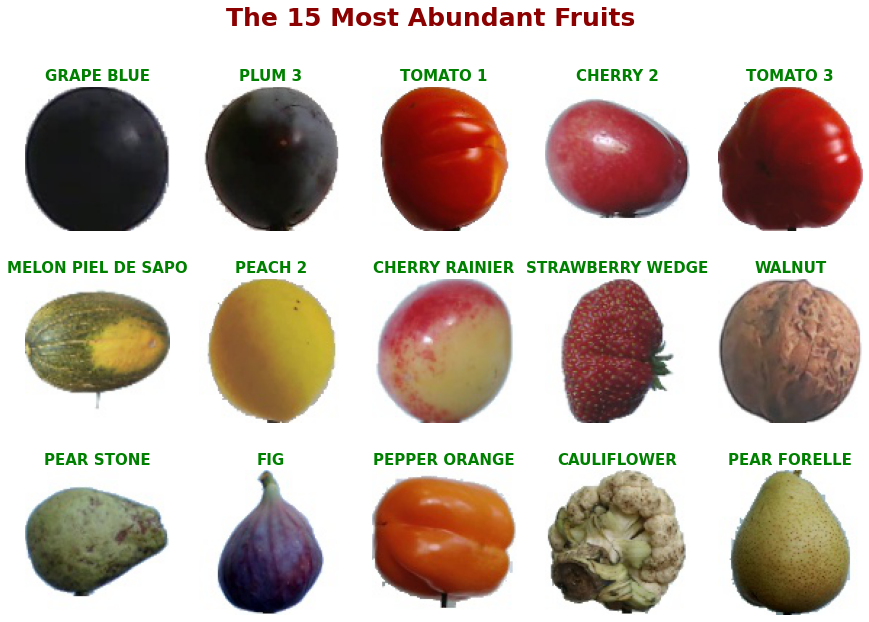

In [10]:
plt.figure(figsize=(15,10))
how_many_fruits = len(x)

for i in range(how_many_fruits):
    fruits = train_fruits[train_fruits["Fruits"] == x[i]]["Fruits Image"].values [1]
    
    plt.subplot(3,5,i+1)
    img = load_img(train_path + fruits)
    plt.imshow(img)
    plt.title(x[i].upper(), color = "green", fontsize = 15 , fontweight = 600)
    plt.axis("off")

plt.suptitle("The 15 Most Abundant Fruits", fontsize = 25 , color = "darkred", fontweight = 'bold')
plt.show()

*****Image's shape:  (100, 100, 3)



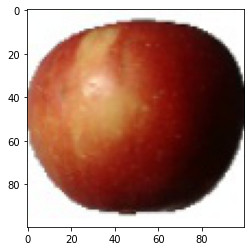

In [11]:
#Image shape

img = load_img('../input/fruits/fruits-360/Training/Apple Braeburn/0_100.jpg')

plt.imshow(img)

print("*****Image's shape: ",img_to_array(img).shape)
print()

In [12]:
# Number of unique fruits

number_classes = glob(train_path + "/*")
number_classes = len(number_classes)

print("Unique number of fruit types: ", number_classes)

Unique number of fruit types:  131


In [13]:
# useful for getting number of files
num_train_files = glob(train_path + '/*/*.jp*g')
num_test_files = glob(test_path + '/*/*.jp*g')

# 2. Modelling (CNNs)

In [14]:
#Apply keras functional API to build model

i = Input(shape = img_to_array(img).shape)

x = Conv2D(filters = 32, kernel_size= (3,3), activation = 'relu')(i)
x = BatchNormalization()(x)
x = Conv2D(filters = 32, kernel_size= (3,3), activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(filters = 64, kernel_size= (3,3), activation = 'relu')(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 64, kernel_size= (3,3), activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(filters = 128, kernel_size= (3,3), activation = 'relu')(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 128, kernel_size= (3,3), activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024,activation= 'relu')(x)
x = Dropout(0.2)(x)
prediction = Dense(number_classes,activation='softmax')(x)

model = Model(i,prediction)

In [15]:
#Compile our model
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 98, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        18496 

In [17]:
epochs = 5
batch_size = 32

# Data Augmentation

In [22]:
# create an instance of ImageDataGenerator
train_gen = ImageDataGenerator(
#   rotation_range=10,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
#   horizontal_flip=True,
#   vertical_flip=True,
#   preprocessing_function=preprocess_input,
    rescale= 1./255
)

test_gen = ImageDataGenerator(rescale= 1./255)


In [23]:
target_size = img_to_array(img).shape[:2]
target_size

(100, 100)

In [24]:

# create generators
train_generator = train_gen.flow_from_directory(
  train_path,
  target_size=target_size,
  shuffle=True,
  batch_size=batch_size,
    color_mode= "rgb",
        class_mode= "categorical"
)

test_generator = test_gen.flow_from_directory(
  test_path,
  target_size=target_size,
  shuffle=False,
  batch_size=batch_size,
    color_mode= "rgb",
        class_mode= "categorical"
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [25]:
#Save best weights
checkpointer_cnn = ModelCheckpoint(filepath = 'basic_cnn_fruits.hdf5', verbose = 1, save_best_only = True)

# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=test_generator,
  epochs=epochs,
    callbacks = [checkpointer_cnn],
  steps_per_epoch= len(num_train_files) // batch_size,
  validation_steps= len(num_test_files) // batch_size,
)

Epoch 1/5
2115/2115 [==============================] - 513s 243ms/step - loss: 0.5340 - accuracy: 0.8898 - val_loss: 1.4199 - val_accuracy: 0.8606

Epoch 00001: val_loss improved from inf to 1.41989, saving model to basic_cnn_fruits.hdf5
Epoch 2/5
2115/2115 [==============================] - 315s 149ms/step - loss: 0.2866 - accuracy: 0.9446 - val_loss: 0.3985 - val_accuracy: 0.9576

Epoch 00002: val_loss improved from 1.41989 to 0.39855, saving model to basic_cnn_fruits.hdf5
Epoch 3/5
2115/2115 [==============================] - 315s 149ms/step - loss: 0.1966 - accuracy: 0.9631 - val_loss: 1.0502 - val_accuracy: 0.9169

Epoch 00003: val_loss did not improve from 0.39855
Epoch 4/5
2115/2115 [==============================] - 315s 149ms/step - loss: 0.1469 - accuracy: 0.9725 - val_loss: 0.3479 - val_accuracy: 0.9588

Epoch 00004: val_loss improved from 0.39855 to 0.34791, saving model to basic_cnn_fruits.hdf5
Epoch 5/5
2115/2115 [==============================] - 318s 151ms/step - loss: 

In [26]:
# load the weights that yielded the best validation accuracy
model.load_weights('basic_cnn_fruits.hdf5')

In [27]:
model.save("my_basic_cnn_model")

In [28]:
basic_cnn_mode = tf.keras.models.load_model("my_basic_cnn_model")


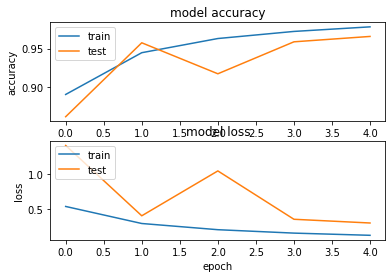

In [29]:
import matplotlib.pyplot as plt 
plt.figure(1)  
   
 # summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(r.history['accuracy'])  
plt.plot(r.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(r.history['loss'])  
plt.plot(r.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

In [ ]:
print()

In [35]:
# Predict the label of the test_images
pred = basic_cnn_mode.predict(test_generator)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Apple Braeburn', 'Apple Braeburn', 'Apple Braeburn', 'Apple Braeburn', 'Apple Braeburn']


In [ ]:
y_test = test_generator.classes

y_pred = basic_cnn_mode.predict(test_generator)
y_pred = np.argmax(y_pred,axis=1)

In [59]:
# Map the label
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

y_test = [labels[k] for k in y_test]
y_pred = [labels[k] for k in y_pred]

In [61]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test,y_pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 96.59%


In [62]:
from sklearn.metrics import classification_report
class_report = classification_report(y_test, y_pred, zero_division=1)
print(class_report)

                     precision    recall  f1-score   support

     Apple Braeburn       0.99      0.66      0.80       164
 Apple Crimson Snow       0.99      0.72      0.84       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       1.00      1.00      1.00       164
     Apple Golden 3       0.77      0.67      0.72       161
 Apple Granny Smith       0.76      1.00      0.86       164
    Apple Pink Lady       0.79      1.00      0.88       152
        Apple Red 1       1.00      1.00      1.00       164
        Apple Red 2       0.80      1.00      0.89       164
        Apple Red 3       1.00      1.00      1.00       144
Apple Red Delicious       1.00      0.99      1.00       166
 Apple Red Yellow 1       1.00      0.98      0.99       164
 Apple Red Yellow 2       0.90      1.00      0.95       219
            Apricot       1.00      1.00      1.00       164
            Avocado       1.00      1.00      1.00       143
       Avocado ripe    

# 3. Transfer learning with VGG16 and ResNet50

## 3.1. VGG16

In [63]:
from keras.applications.vgg16 import VGG16, preprocess_input

# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=img_to_array(img).shape, weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(vgg.output)
x = Dense(1000, activation='relu')(x)
prediction = Dense(number_classes, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
____________________________________________________________

In [64]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

In [65]:
# create an instance of ImageDataGenerator
train_gen = ImageDataGenerator(
#   rotation_range=10,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
#   horizontal_flip=True,
#   vertical_flip=True,
  preprocessing_function=preprocess_input,
    rescale= 1./255
)

test_gen = ImageDataGenerator(rescale= 1./255,
                             preprocessing_function=preprocess_input)

In [66]:
# create generators
train_generator = train_gen.flow_from_directory(
  train_path,
  target_size=target_size,
  shuffle=True,
  batch_size=batch_size
)

test_generator = test_gen.flow_from_directory(
  test_path,
  target_size=target_size,
  shuffle=True,
  batch_size=batch_size
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In Keras, using fit() and predict() is fine for smaller datasets which can be loaded into memory. But in practice, for most practical-use cases, almost all datasets are large and cannot be loaded into memory at once.

The solution is to use **fit_generator()** and predict_generator() with custom data generator functions which can load images to memory during training or predicting.

In [67]:
#Save best weights
checkpointer_vgg = ModelCheckpoint(filepath = 'tl_vgg_fruits.hdf5', verbose = 1, save_best_only = True)

# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=test_generator,
  epochs=epochs,
        callbacks = [checkpointer_vgg],
  steps_per_epoch=len(num_train_files) // batch_size,
  validation_steps=len(num_test_files) // batch_size,
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
2115/2115 [==============================] - 1920s 906ms/step - loss: 1.2301 - accuracy: 0.7126 - val_loss: 0.4106 - val_accuracy: 0.9090

Epoch 00001: val_loss improved from inf to 0.41061, saving model to tl_vgg_fruits.hdf5
Epoch 2/5
2115/2115 [==============================] - 1914s 905ms/step - loss: 0.1069 - accuracy: 0.9668 - val_loss: 0.3785 - val_accuracy: 0.9401

Epoch 00002: val_loss improved from 0.41061 to 0.37848, saving model to tl_vgg_fruits.hdf5
Epoch 3/5
2115/2115 [==============================] - 1913s 905ms/step - loss: 0.0816 - accuracy: 0.9767 - val_loss: 0.5981 - val_accuracy: 0.9099

Epoch 00003: val_loss did not improve from 0.37848
Epoch 4/5
2115/2115 [==============================] - 1913s 905ms/step - loss: 0.0696 - accuracy: 0.9822 - val_loss: 0.4569 - val_accuracy: 0.9493

Epoch 00004: val_loss did not improve from 0.37848
Epoch 5/5
2115/2115 [==============================] - 1913s 904ms/step - loss: 0.0617 - accuracy: 0.9850 - val_loss: 0.4599

In [68]:
# load the weights that yielded the best validation accuracy
model.load_weights('tl_vgg_fruits.hdf5')

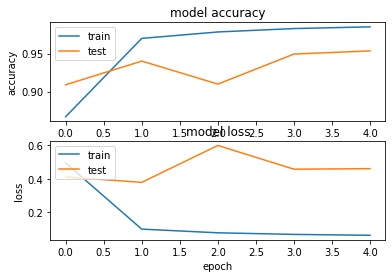

In [69]:
import matplotlib.pyplot as plt 
plt.figure(1)  
   
 # summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(r.history['accuracy'])  
plt.plot(r.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(r.history['loss'])  
plt.plot(r.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

## 3.2. ResNet50

In [ ]:
from keras.applications.resnet50 import ResNet50, preprocess_input

# add preprocessing layer to the front of VGG
res = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in res.layers:
    layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(res.output)
x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=res.input, outputs=prediction)

# view the structure of the model
model.summary()

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

In [ ]:
#Save best weights
checkpointer_resnet = ModelCheckpoint(filepath = 'tl_resnet_fruits.hdf5', verbose = 1, save_best_only = True)

# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=test_generator,
  epochs=epochs,
    callbacks = [checkpointer_resnet],
  steps_per_epoch=len(num_train_files) // batch_size,
  validation_steps=len(num_test_files) // batch_size,
)